In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

#### Loading Data 

Data contains 25000 images of cats and dogs, 2 classes. 

In [2]:
import zipfile
with zipfile.ZipFile('./train.zip') as file:
    file.extractall()

In [3]:
os.listdir('./train/')[0:10]

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg']

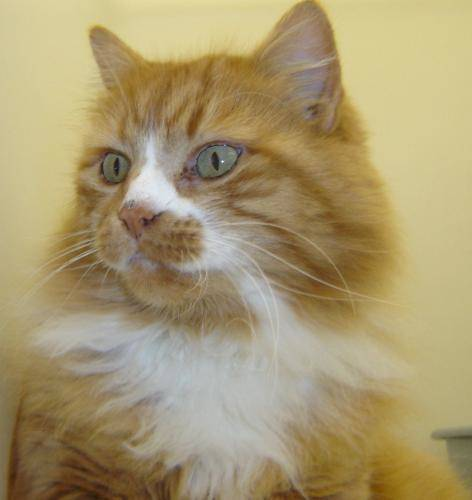

In [4]:
from PIL import Image
Image.open('./train/cat.10009.jpg')

In [5]:
pxl_size=(200,200)
path='./train'

Creating read function that creates a data iterator

In [6]:
def read_data(batch_size,path,pxl_size):
    files=os.listdir(path)
    i=0
    length=batch_size//2
    labels=[re.search(string=p,pattern='^[a-z]*').group() for p in files]
    le=LabelEncoder()
    le.fit(labels)
    
    while((i+1)*length<(len(files)/2)):
        x_data=np.zeros((batch_size,pxl_size[1],pxl_size[0],3))
        y_data=[]
        j=0
        for k in range(i*length,(i+1)*length):
            img=Image.open(os.path.join(path,files[k])).resize(pxl_size)
            x_data[j,:,]=np.array(img)/255.0
            y_data.append(labels[k])

            img=Image.open(os.path.join(path,files[-k-1])).resize(pxl_size)
            x_data[j+1,:,]=np.array(img)/255.0
            y_data.append(labels[-k-1])
            j=j+2
        i+=1
        y_data=le.transform(y_data)
        ind=np.random.permutation(batch_size)
        x_data=x_data[ind,]
        y_data=y_data[ind]
        yield (x_data,y_data)

### Creating model

Lets create a convolutional Neural Network to learn about the features of the images of Cats and dogs.

I took a reference to VGG-16 by Visual Graph Group and Alexnet to create this convolutional network.

In [7]:
h0=keras.layers.Conv2D(32,kernel_size=(4,4),strides=(2,2),padding='valid',input_shape=\
                       (pxl_size[1],pxl_size[0],3),activation='relu')
h1=keras.layers.MaxPool2D(pool_size=(3,3),strides=(3,3))

In [8]:
h2=keras.layers.Conv2D(64,kernel_size=(4,4),strides=(1,1),padding='same',\
                       activation='relu')
h3=keras.layers.MaxPool2D(pool_size=(3,3),strides=(3,3))

In [9]:
h4=keras.layers.Conv2D(128,kernel_size=(3,3),strides=(1,1),padding='same',\
                       activation='relu')
h5=keras.layers.Conv2D(128,kernel_size=(3,3),strides=(1,1),padding='same',\
                       activation='relu')
h6=keras.layers.MaxPool2D(pool_size=(3,3),strides=(3,3))

Assembling the model with all convolutional layers

In [10]:
model=keras.Sequential(name='CNN')
model.add(h0)
model.add(h1)
model.add(h2)
model.add(h3)
model.add(h4)
model.add(h5)
model.add(h6)

In [11]:
d1=keras.layers.Flatten(name='Flatten')
d2=keras.layers.Dense(1000,'relu',name='Dense_1')
d3=keras.layers.Dropout(0.2)
d4=keras.layers.Dense(500,'relu',name='Dense_2')
d5=keras.layers.Dropout(0.2)
d6=keras.layers.Dense(2,activation='softmax',name='Output')

Adding dense layers to the model

In [12]:
model.add(d1)
model.add(d2)
model.add(d3)
model.add(d4)
model.add(d5)
model.add(d6)

In [13]:
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 99, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0       

Training model

In [14]:
model.compile('adam','sparse_categorical_crossentropy',metrics=['accuracy'])
batch_size=128
epochs=4
for i in range(0,epochs):
    gen=read_data(batch_size, path, pxl_size)
    print(f'Epoch {i+1}/{epochs}====>\n')
    model.fit(gen,batch_size=batch_size,epochs=1)

Epoch 1/4====>

195/195 [==============================] - 336s 2s/step - loss: 0.6499 - accuracy: 0.5951
Epoch 2/4====>

195/195 [==============================] - 331s 2s/step - loss: 0.4341 - accuracy: 0.7970
Epoch 3/4====>

195/195 [==============================] - 326s 2s/step - loss: 0.3507 - accuracy: 0.8459
Epoch 4/4====>

195/195 [==============================] - 316s 2s/step - loss: 0.2867 - accuracy: 0.8780


In [15]:
keras.models.save_model(model,'./CNN_model.h5',save_format='h5')